In [78]:
import sys # for gioia to load aiohttp - delete before finalizing
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

In [79]:
# to import modules locally without having installed the entire package
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [80]:
import subprocess
import numpy as np
from scipy.stats import norm
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

# Stock Market Similarity Searches

We have included daily closing prices for 379 stocks on the S&P 500. The switch below determines whether to load daily prices or dailiy returns.

In [90]:
# True: daily prices
# False: daily returns
data_prices = True

if data_prices:
    file_name = 'data/prices.json'
    title = 'Daily Stock Price'
else:
    file_name = 'data/returns.json'
    title = 'Daily Stock Return'

### Initialization

Load the database server.

In [91]:
# when running from the terminal
# python go_server.py

# here we load the server as a subprocess for demonstration purposes
server = subprocess.Popen(['python', '../go_server.py'])

Load the database webserver.

In [92]:
# when running from the terminal
# python go_webserver.py

# here we load the server as a subprocess for demonstration purposes
webserver = subprocess.Popen(['python', '../go_webserver.py'])

Import the web interface and initialize it.

In [93]:
from webserver import *

In [94]:
web_interface = WebInterface()

Import the `timeseries` package and load the stock data.

In [95]:
from timeseries import *

In [96]:
with open(file_name) as f:    
    stock_data = json.load(f)
    
# keep track of the stock tickers
stocks = sorted(list(stock_data.keys()))
num_stocks = len(stocks)

# check the number of market days in the year
num_days = len(stock_data[stocks[0]])

# randomly pick 10 stocks to exclude - we'll use these later
stocks_exclude = np.random.choice(stocks, size=5, replace=False)

Insert the time series data into the database, remembering to exclude the 10 stocks we picked out.

In [97]:
for stock in stocks:
    if stock not in stocks_exclude:
        web_interface.insert_ts(pk=stock, ts=TimeSeries(range(num_days), stock_data[stock]))

Look at the first 10 stocks, to check that it has been loaded correctly.

In [98]:
# let's look at the first 10 stocks
results = web_interface.select(fields=[], additional={'sort_by': '+pk', 'limit': 10})
results

OrderedDict([('A', OrderedDict([('pk', 'A')])),
             ('AA', OrderedDict([('pk', 'AA')])),
             ('ABC', OrderedDict([('pk', 'ABC')])),
             ('ABT', OrderedDict([('pk', 'ABT')])),
             ('ADI', OrderedDict([('pk', 'ADI')])),
             ('ADM', OrderedDict([('pk', 'ADM')])),
             ('AEE', OrderedDict([('pk', 'AEE')])),
             ('AEP', OrderedDict([('pk', 'AEP')])),
             ('AES', OrderedDict([('pk', 'AES')])),
             ('AET', OrderedDict([('pk', 'AET')]))])

### Vantage Point Search

Pick 30 of the 379 stocks randomly as vantage points.

In [99]:
num_vps = 30

random_vps = np.random.choice(range(num_stocks), size=num_vps, replace=False)
vpkeys = [stocks[s] for s in random_vps]

Mark the stocks as vantage points.

In [100]:
for i in range(num_vps):
    web_interface.insert_vp(vpkeys[i])

Pick a random stock to carry out a similarity search.

In [101]:
stock = np.random.choice(stocks_exclude)
stock

'UPS'

Run the vantage point similarity search.

In [102]:
result = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data[stock]), 1)
result

OrderedDict([('HON', 0.44594932769628076)])

Visualize the results, to check how similar the two time series are.

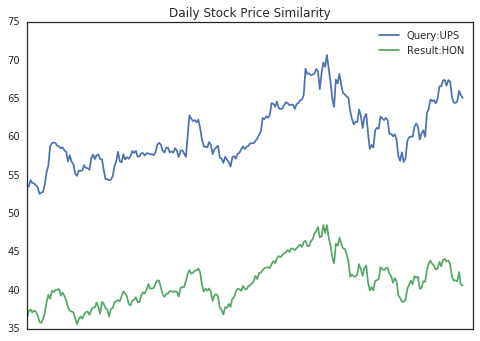

In [103]:
# visualize the results
plt.plot(stock_data[stock], label='Query:' + stock)
plt.plot(stock_data[list(result)[0]], label='Result:' + list(result)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title(title + ' Similarity')
plt.show()

### iSAX Tree Search

### Termination

Remember to terminate any outstanding processes.

In [104]:
server.terminate()
webserver.terminate()
web_interface = None